# EBUS-ENSO Timeseries Analysis
- Taking output from the EBUS_extraction.py script to analyze it in coordination with Adam Phillip's CVDP output (starting with Nino 3.4)
- First step is to work with CCS, since that's a comfortable area.

In [20]:
# UNIX-style globbing
import glob

# Numerics
import numpy as np
import pandas as pd
import xarray as xr
from scipy import signal
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import *

from mpl_toolkits.basemap import Basemap

import seaborn as sns
sns.set(color_codes=True)

import statsmodels.api as sm

# Functions
- For visibility in the Notebook

In [2]:
def detrend_nino(x):
    return signal.detrend(x)

In [3]:
def compute_correlations(carbonData, climateData):
    slope, intercept, r_value, p_value, std_err = stats.linregress(climateData, carbonData)
    return slope, r_value, r_value**2, p_value

In [4]:
def smooth_series(x, len):
    return pd.rolling_mean(x, len, center=False)

In [14]:
def setup_map(ax, lon, lat):
    m = Basemap(projection='eqdc',
                lat_0=np.nanmedian(lat),
                lon_0=np.nanmedian(lon),
                llcrnrlon=np.nanmin(lon),
                urcrnrlon=np.nanmax(lon),
                llcrnrlat=np.nanmin(lat),
                urcrnrlat=np.nanmax(lat),
                resolution='c')
   # m.drawcoastlines()
   # m.fillcontinents(color='black')
    m.drawmapboundary(fill_color='white')
    m.drawparallels(np.arange(np.floor(np.nanmin(lat)), 
                              np.ceil(np.nanmax(lat)), 3),
                   labels=[True,False,False,False])
    m.drawmeridians(np.arange(np.floor(np.nanmin(lon)), 
                              np.ceil(np.nanmax(lon)), 3),
                   labels=[False, False, False, False])
    return m

# Smoothed FG_CO2 Correlations
- Post-processed on Yellowstone, saved dataframe to csv.

In [6]:
enso = pd.read_csv('/glade/u/home/rbrady/projects/EBUS_BGC_Variability/data/processed/smoothed_fgco2_vs_enso', index_col=0)
#pdo = pd.read_csv('smoothed_fgco2_vs_pdo', index_col=0)
#npo = pd.read_csv('smoothed_fgco2_vs_npo', index_col=0)

In [ ]:
enso

In [ ]:
fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(111)
ax1.scatter(enso['R Value'], pdo['R Value'])

# Overhead of our Region
- 25N - 45N; filtered to 34N - 44N
- 130W - 110W
- Quick ensemble climatology

In [32]:
fileDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/FG_CO2/'
ds_gas = xr.open_mfdataset(fileDir + '*.nc', concat_dim='ensemble')

In [33]:
lat = ds_gas['TLAT'][0].values
lon = ds_gas['TLONG'][0].values
co2data = ds_gas['FG_CO2'][0].mean(dim='time').values
co2data_masked = np.ma.array(co2data, mask=np.isnan(co2data))

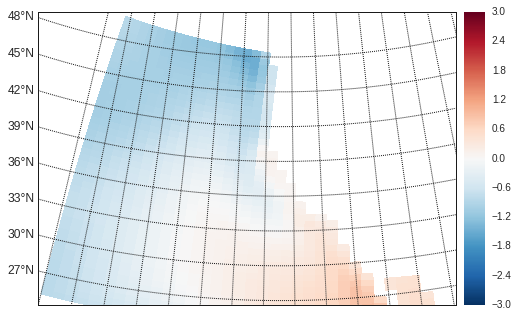

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111)
m = setup_map(ax, lon, lat)
m.pcolormesh(lon, lat, co2data_masked, vmin=-3, vmax=3,
          latlon=True, cmap="RdBu_r")
m.colorbar()

In [37]:
# Translate to Chavez bounds.
ds_gas = ds_gas.where(ds_gas['TLAT'] >= 34).where(ds_gas['TLAT'] <= 44)

In [83]:
# Just need to nan out rows in DXT that don't have coastline via REGION_MASK and then use .where() filter.
regionMask = ds_gas['REGION_MASK'][0]
#regionMask[40,:]
data = ds_gas['FG_CO2'][0].mean(dim='time')
#data.plot()
~np.isnan(data)

<xarray.DataArray 'FG_CO2' (nlat: 46, nlon: 40)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)
Coordinates:
  * nlat      (nlat) int64 265 266 267 268 269 270 271 272 273 274 275 276 ...
  * nlon      (nlon) int64 226 227 228 229 230 231 232 233 234 235 236 237 ...
    TLAT      (nlat, nlon) float64 25.14 25.12 25.09 25.07 25.04 25.02 24.99 ...
    TLONG     (nlat, nlon) float64 215.0 216.1 217.3 218.4 219.5 220.6 221.8 ...
    ensemble  int64 0

In [11]:
# Convert to km
ds_gas['DXT'] = ds_gas['DXT'] / 100 / 1000

In [59]:
lat = ds_gas['TLAT'][0].values
lon = ds_gas['TLONG'][0].values
co2data = ds_gas['FG_CO2'][0].mean(dim='time').values
co2data_masked = np.ma.array(co2data, mask=np.isnan(co2data))

In [74]:
# Cumulative sum of DXTs to figure out how far offshore each box is.
x = ds_gas['DXT'][0].values
x_masked = np.ma.array(x, mask=np.isnan(co2data))
dxt_cum = np.cumsum(x_masked[:, ::-1], axis=1)[:, ::-1]
ds_gas['DXT_Cum'] = (('nlat', 'nlon'), dxt_cum)

In [77]:
# Filter out within 500km.
ds_gas = ds_gas.where(ds_gas['DXT_Cum'] <= 500)

In [78]:
lat = ds_gas['TLAT'][0].values
lon = ds_gas['TLONG'][0].values
co2data = ds_gas['FG_CO2'][0].mean(dim='time').values
co2data_masked = np.ma.array(co2data, mask=np.isnan(co2data))

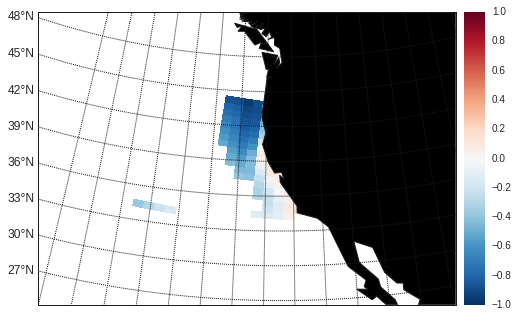

In [79]:
fig = plt.figure()
ax = fig.add_subplot(111)
m = setup_map(ax, lon, lat)
m.pcolormesh(lon, lat, co2data_masked, vmin=-1, vmax=1,
          latlon=True, cmap="RdBu_r")
m.colorbar()

# Extracting Timeseries for Analysis
- Working on one ensemble member at a time for testing. 
- Time series product is a weighted mean of gas flux over the region.

In [ ]:
fileDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/FG_CO2/'
ds_gas = xr.open_mfdataset(fileDir + '*.nc', concat_dim='ensemble')

In [ ]:
# Add in ensemble labeling for clarity
ens = ['001', '002', '009', '010', '011', '012',
       '013', '014', '015', '016', '017', '018',
       '019', '020', '021', '022', '023', '024',
       '025', '026', '027', '028', '029', '030',
       '031', '032', '033', '034', '035', '101',
       '102', '103', '104', '105']
ds_gas['ensemble'] = ens

In [ ]:
# Subtract out the ensemble mean
ds_residuals = ds_gas['FG_CO2'] - ds_gas['FG_CO2'].mean(dim='ensemble')

# Area-weighting. ds_residuals now is the area-weighted
ds_residuals = ((ds_residuals * ds_gas['TAREA'])
     .sum(dim='nlat').sum(dim='nlon')) / ds_gas['TAREA'][0].sum()

ds_residuals.attrs['Units'] = "mol/m2/yr"
ds_residuals.attrs['Description'] = "Weighted-average FG_CO2 in the CCS with forced component removed (residuals)."

# CVDP -- Adam Phillips
- Messing with the climate diagnostics that Adam Phillips provides

In [ ]:
fileDir = '/glade/p/work/rbrady/cesmLE_CVDP/extracted_vars/'
ds_cvdp = xr.open_mfdataset(fileDir + '*.nc', decode_times=False, concat_dim='ensemble')

In [ ]:
ds_cvdp = ds_cvdp.rename({'npo_pc_mon': 'npo', 'pdo_timeseries_mon': 'pdo'})

In [ ]:
times = pd.date_range('1920-01', '2016-01', freq='M')
ens = ['001', '002', '009', '010', '011', '012',
       '013', '014', '015', '016', '017', '018',
       '019', '020', '021', '022', '023', '024',
       '025', '026', '027', '028', '029', '030',
       '031', '032', '033', '034', '035', '101',
       '102', '103', '104', '105']
ds_cvdp['time'] = times
ds_cvdp['ensemble'] = ens

In [ ]:
ds_cvdp = ds_cvdp.apply(detrend_nino)
ds_cvdp

In [ ]:
scompute_correlations(ds_residuals[0].values, ds_cvdp['nino34'][0].values)

# Correlation, Regression, and Autocorrelation

After detrending (removing ensemble mean) and obtaining the natural CO2 flux, the issue is that the FG_CO2 time series and Nino 3.4 timeseries are autocorrelated (have serial correlation). The blue box represents 95% confidence bands for significant autocorrelation. Anything that falls outside of that box is significantly correlated. 
    - Interestingly, the NPO has no autocorrelation issues.

In [ ]:
ts1 = ds_residuals[0].values
ts2 = ds_cvdp['nino34'][0]
ts3 = ds_cvdp['pdo'][0]
ts4 = ds_cvdp['npo'][0]

fig = plt.figure(figsize=(12,12))

ax1 = fig.add_subplot(4,1,1)
ax1.set_ylabel("FG_CO2 Autocorrelation")
sm.graphics.tsa.plot_acf(ts1, lags=40, ax=ax1)

ax2 = fig.add_subplot(4,1,2)
ax2.set_ylabel("Nino 3.4 Autocorrelation")
sm.graphics.tsa.plot_acf(ts2, lags=40, ax=ax2)

ax3 = fig.add_subplot(4,1,3)
ax3.set_ylabel("PDO Autocorrelation")
sm.graphics.tsa.plot_acf(ts3, lags=40, ax=ax3)

ax4 = fig.add_subplot(4,1,4)
ax4.set_ylabel("NPO Autocorrelation")
sm.graphics.tsa.plot_acf(ts4, lags=40, ax=ax4)

# Anomaly Plot

In [ ]:
ds_residuals[0]

In [ ]:
nino = ds_cvdp['nino34']

fig = plt.figure(figsize=(18,3))
ax1 = fig.add_subplot(111)
ax1.grid('off')

ax1.bar(nino[0].time.values, nino[0].where(nino[0] > 0).values, color="none", edgecolor="red")
ax1.bar(nino[0].time.values, nino[0].where(nino[0] < 0).values, color="none", edgecolor="blue")

ax2 = ax1.twinx()
ax2.plot(ds_residuals[0].time.values, ds_residuals[0].values, '-k')
ax2.grid('off')

ax1.set_ylabel("Nino3.4 Index")
ax2.set_ylabel("FG_CO2 Anomalies")

plt.savefig("enso-fgco2-timeseries.png")

# Rolling Mean

In [ ]:
r = ds_residuals[0].to_pandas()

In [ ]:
test = pd.rolling_mean(r, 12, center=False)
fig = plt.figure(figsize=(16,3))
r.plot()
test.plot(color="k")

In [ ]:
nino = ds_cvdp['nino34']

fig = plt.figure(figsize=(18,3))
ax1 = fig.add_subplot(111)
ax1.grid('off')

ax1.bar(nino[0].time.values, nino[0].where(nino[0] > 0).values, color="none", edgecolor="red")
ax1.bar(nino[0].time.values, nino[0].where(nino[0] < 0).values, color="none", edgecolor="blue")

ax2 = ax1.twinx()
ax2.plot(nino[0].time.values, test.values, '-k')
ax2.grid('off')

ax1.set_ylabel("Nino3.4 Index")
ax2.set_ylabel("FG_CO2 Anomalies")

plt.savefig("enso-fgco2-timeseries.png")

Here I use a simple least-squares linear regression to use three different climate indices as a predictor for residual CO2 flux in the CCS. We regress the FG_CO2 residuals onto a nino3.4 index, PDO index, and NPO index.

In [ ]:
ts1 = ds_residuals[0].values
ts2 = ds_cvdp['nino34'][0].values
ts3 = ds_cvdp['pdo'][0].values
ts4 = ds_cvdp['npo'][0].values

In [ ]:
# Hatching together a correlation matrix.
nino_correlation = np.zeros([34,1])
pdo_correlation = np.zeros([34, 1])
npo_correlation = np.zeros([34, 1])

for idx in np.arange(0,34, 1):
    carbonSeries = ds_residuals[idx].values
    nino = ds_cvdp['nino34'][idx].values
    pdo = ds_cvdp['pdo'][idx].values
    npo = ds_cvdp['npo'][idx].values
    
    nino_correlation[idx] = compute_correlations(carbonSeries, nino)
    pdo_correlation[idx] = compute_correlations(carbonSeries, pdo)
    npo_correlation[idx] = compute_correlations(carbonSeries, npo)

In [ ]:
fig = plt.figure(figsize=(6,18))
st = fig.suptitle("Natural CCS CO2 Flux Correlated with Climate Indices", fontsize="x-large")

ax1 = fig.add_subplot(311)
ax1.scatter(nino_correlation, pdo_correlation, s=36, color="k")
ax1.set_xbound(0, 0.5)
ax1.set_ybound(0, 0.5)
ax1.set_xlabel("Correlation with ENSO")
ax1.set_ylabel("Correlation with PDO")

ax2 = fig.add_subplot(312)
ax2.scatter(nino_correlation, npo_correlation, s=36, color="k")
ax2.set_xbound(0, 0.5)
ax2.set_ybound(-0.5, 0)
ax2.set_xlabel("Correlation with ENSO")
ax2.set_ylabel("Correlation with NPO")

ax3 = fig.add_subplot(313)
ax3.scatter(pdo_correlation, npo_correlation, s=36, color="k")
ax3.set_xbound(0, 0.5)
ax3.set_ybound(-0.5, 0)
ax3.set_xlabel("Correlation with PDO")
ax3.set_ylabel("Correlation with NPO")

fig.tight_layout

fig.savefig("correlation_plot.eps")